In [1]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchinfo import summary
from torchvision import models, datasets, transforms

import os
import random
from PIL import Image
from pathlib import Path

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Plotting Data

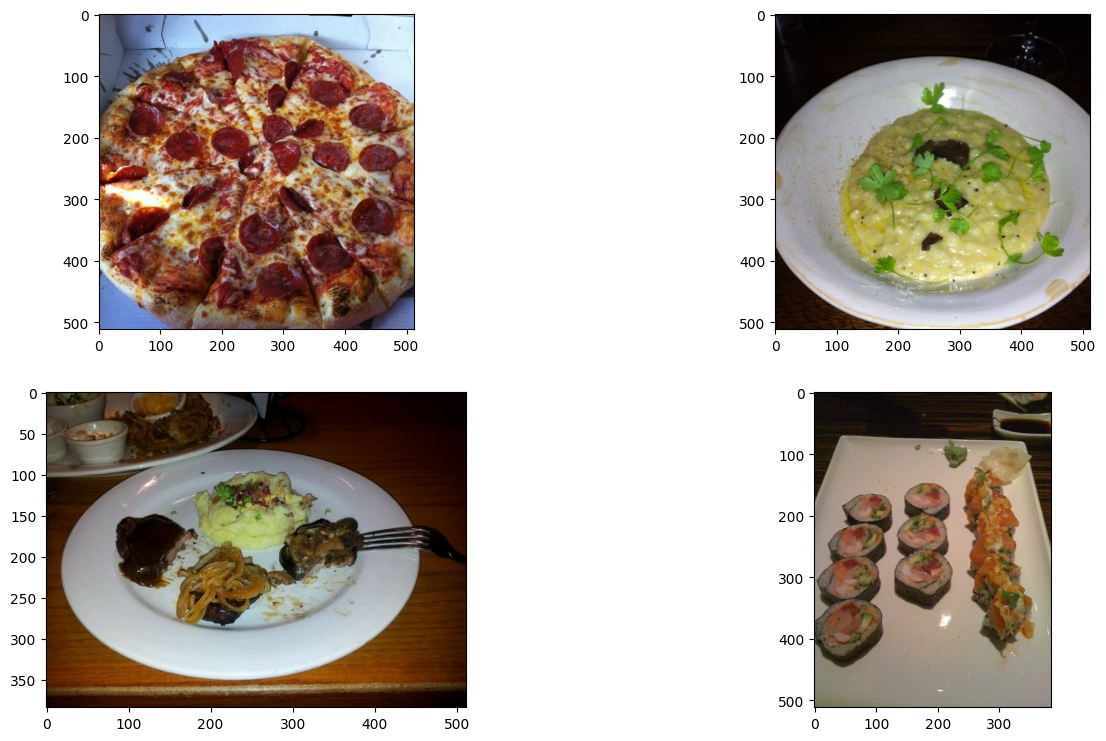

In [3]:
root_dir = "../datasets/food-4/"

fig, ax = plt.subplots(2, 2, figsize=(16, 9))
pizza_image = Image.open(root_dir+'train/pizza/1001116.jpg')
ax[0, 0].imshow(pizza_image)
risotto_image = Image.open(root_dir+'train/risotto/1004412.jpg')
ax[0, 1].imshow(risotto_image)
steak_image = Image.open(root_dir+'train/steak/1000205.jpg')
ax[1, 0].imshow(steak_image)
sushi_image = Image.open(root_dir+'train/sushi/100332.jpg')
ax[1, 1].imshow(sushi_image)
plt.show()

# Preparing Data

In [6]:
NUM_WORKERS = os.cpu_count()
weights = models.EfficientNet_B0_Weights
batch_size=32

simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(root_dir+'train', transform=simple_transform)
test_data = datasets.ImageFolder(root_dir+'test', transform=simple_transform)

train_dataloader = torch.utils.data.DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=NUM_WORKERS,
      pin_memory=True,
)
test_dataloader = torch.utils.data.DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False, # don't need to shuffle test data
      num_workers=NUM_WORKERS,
      pin_memory=True,
  )
train_dataloader, test_dataloader, train_data.classes, train_data.class_to_idx

(<torch.utils.data.dataloader.DataLoader at 0x7fcdf96bc090>,
 ['pizza', 'risotto', 'steak', 'sushi'],
 {'pizza': 0, 'risotto': 1, 'steak': 2, 'sushi': 3})

# Loading Model

In [17]:
model = models.efficientnet_b0(weights=weights)
summary(model, (32, 3, 224, 224))

/home/avyakta/Desktop/coding/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 1000]                --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        1,448
│    └─Sequential: 2-3                                  [32, 24, 56, 56]          --
│    │    └─MBConv: 3-5                                 [32, 24, 56, 56]          6,004
│    │    └─MBConv: 3-6                              

In [18]:
del model.classifier[0]
model.classifier[0] = nn.Linear(1280, 4)
for layers in list(model.features.children())[0:5]:
    for param in layers.parameters():
        param.requires_grad = False

In [19]:
# Freezing the base model and changing the output layer to suit our needs
# for param in model.features.parameters():
#     param
#     param.requires_grad = False

# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# model.classifier[1] = nn.Linear(1280, 4)
summary(model, (32, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 4]                   --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        (864)
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        (64)
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        (1,448)
│    └─Sequential: 2-3                                  [32, 24, 56, 56]          --
│    │    └─MBConv: 3-5                                 [32, 24, 56, 56]          (6,004)
│    │    └─MBConv: 3-6                      

In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.001)

# Training Model

In [21]:
torch.manual_seed(999)
torch.cuda.manual_seed(999)

def train_step(model, dataloader,loss_fn,optimizer, device):
    model.train()
    train_loss, train_acc = 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss+=loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model, dataloader,loss_fn,optimizer, device):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [32]:
EPOCHS = 30
results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

for epoch in range(EPOCHS):
    train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
    test_loss, test_acc  = test_step(model, test_dataloader, loss_fn, optimizer, device)

    print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

Epoch: 1 | train_loss: 0.0402 | train_acc: 0.9894 | test_loss: 0.1625 | test_acc: 0.9492
Epoch: 2 | train_loss: 0.0446 | train_acc: 0.9884 | test_loss: 0.1602 | test_acc: 0.9434
Epoch: 3 | train_loss: 0.0407 | train_acc: 0.9897 | test_loss: 0.1547 | test_acc: 0.9482
Epoch: 4 | train_loss: 0.0434 | train_acc: 0.9904 | test_loss: 0.1597 | test_acc: 0.9482
Epoch: 5 | train_loss: 0.0374 | train_acc: 0.9922 | test_loss: 0.1588 | test_acc: 0.9453
Epoch: 6 | train_loss: 0.0454 | train_acc: 0.9897 | test_loss: 0.1632 | test_acc: 0.9424
Epoch: 7 | train_loss: 0.0402 | train_acc: 0.9897 | test_loss: 0.1634 | test_acc: 0.9473
Epoch: 8 | train_loss: 0.0332 | train_acc: 0.9957 | test_loss: 0.1626 | test_acc: 0.9492
Epoch: 9 | train_loss: 0.0413 | train_acc: 0.9877 | test_loss: 0.1606 | test_acc: 0.9473
Epoch: 10 | train_loss: 0.0323 | train_acc: 0.9947 | test_loss: 0.1587 | test_acc: 0.9492
Epoch: 11 | train_loss: 0.0343 | train_acc: 0.9943 | test_loss: 0.1626 | test_acc: 0.9473
Epoch: 12 | train_l

In [34]:
torch.save(model, './model_SDG')

# Evaluting Model

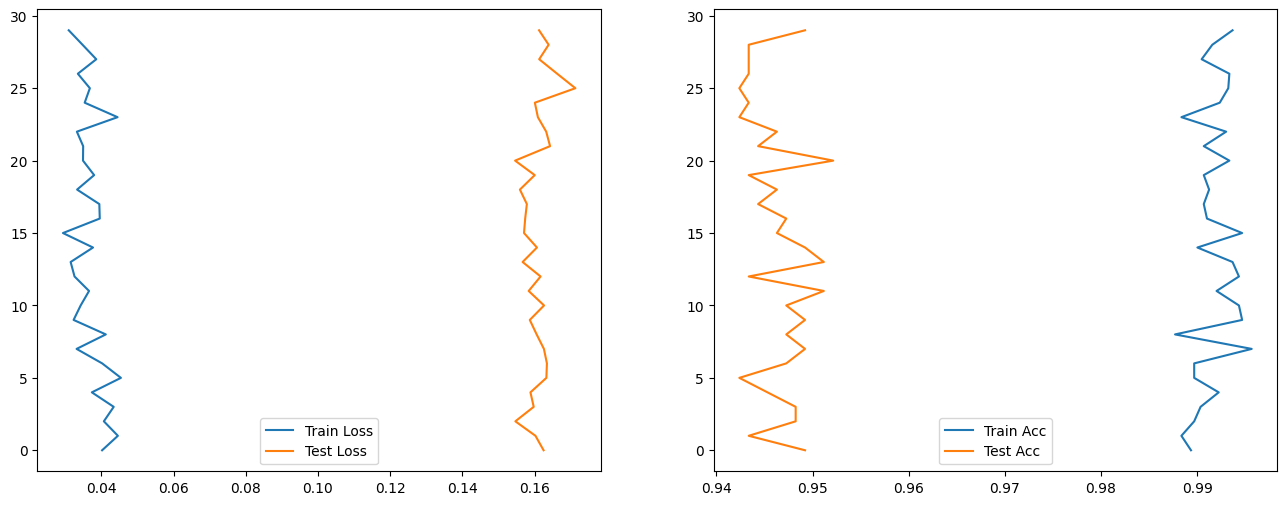

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(results["train_loss"], range(EPOCHS), label='Train Loss')
ax1.plot(results["test_loss"], range(EPOCHS), label='Test Loss')
ax1.legend()

ax2.plot(results["train_acc"], range(EPOCHS), label='Train Acc')
ax2.plot(results["test_acc"], range(EPOCHS), label='Test Acc')
ax2.legend()

plt.show()

# Making Prediction

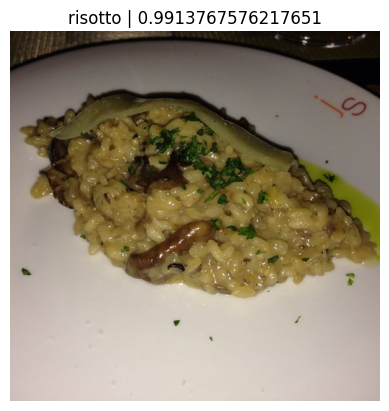

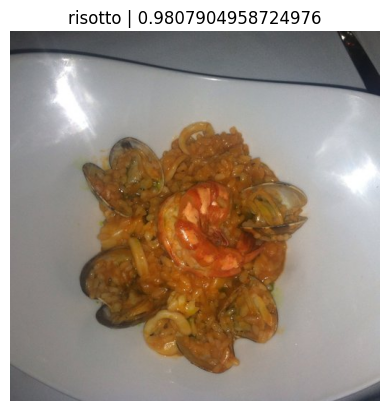

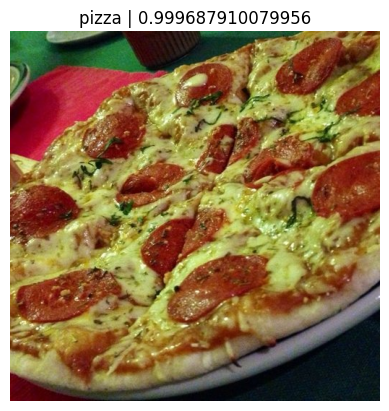

In [11]:
NUM_OF_PREDICTION = 3
IMAGES_PATHS = list(Path(root_dir+'test').glob("*/*.jpg"))
images = random.sample(population=IMAGES_PATHS, k=NUM_OF_PREDICTION)

for img_path in images:
    img = Image.open(img_path)

    transformed_img = simple_transform(img)

    model.eval()
    with torch.inference_mode():
        output = model(transformed_img)
        pred = torch.softmax(output, dim=1).squeeze(0)
        ans = torch.argmax(pred, 0)
    plt.figure()
    plt.title(f'{train_data.classes[ans]} | {pred[ans]}')
    plt.imshow(img)
    plt.axis(False)

In [15]:
import torch
from PIL import Image
img = Image.open('/home/avyakta/Downloads/DOMICILE ANUSHKA.jpg')
transformed_img = simple_transform(img).unsqueeze(0).to(device)
model_sdg = torch.load('./model_SDG')
model_sdg(transformed_img)

tensor([[ 0.2087, -0.3030, -0.0415, -0.1746]], device='cuda:0',
       grad_fn=<AddmmBackward0>)